### Функции потерь

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.datasets import make_classification
from sklearn.metrics import log_loss, hinge_loss, zero_one_loss
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [4]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_classes=3,
                           n_clusters_per_class=1, shift=4.77, scale=3.92, class_sep=1, random_state=2, )


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.4, random_state=42,)

Hinge Loss
$$ max(0, 1 - y \cdot \hat{y}) $$

Logistic Loss 
$$ -\sum_{c=1}^My_{o,c}\log(p_{o,c}) $$

0-1 Loss
$$ -\sum_{c=1}^{M-1} 1 [y_i \neq \hat{y}_i]$$

In [5]:
x = list(range(1, 121, 2))
ll_train = []
ll_test = []
hl_train = []
hl_test = []
zol_train = []
zol_test = []

for n_neighbors in tqdm(x):
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform', p=2))
    ])
    
    pipe.fit(X_train, y_train)
    preds_train = pipe.predict(X_train)
    preds_test = pipe.predict(X_test)
    probas_train = pipe.predict_proba(X_train)
    probas_test = pipe.predict_proba(X_test)
    
    zerooneloss = zero_one_loss(y_train, preds_train)
    zol_train.append(zerooneloss)
    zerooneloss = zero_one_loss(y_test, preds_test)
    zol_test.append(zerooneloss)
    
    hingeloss = hinge_loss(y_train, probas_train)
    hl_train.append(hingeloss)
    hingeloss = hinge_loss(y_test, probas_test)
    hl_test.append(hingeloss)
    
    logloss = log_loss(y_train, probas_train)
    ll_train.append(logloss)
    logloss = log_loss(y_test, probas_test)
    ll_test.append(logloss)
    

  0%|          | 0/60 [00:00<?, ?it/s]

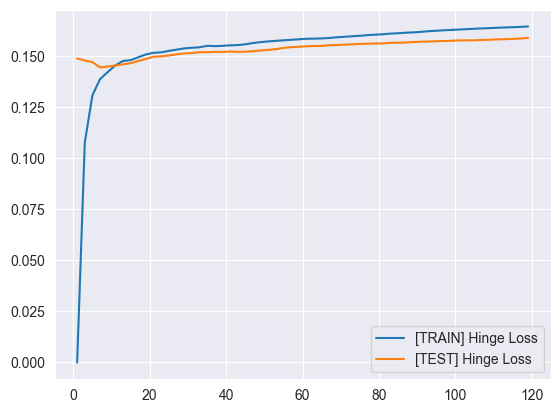

In [8]:
# plt.plot(x, ll_train, label='[TRAIN] Log Loss')
plt.plot(x, hl_train, label='[TRAIN] Hinge Loss')
# plt.plot(x, zol_train, label='[TRAIN] 0-1 Loss')
# plt.plot(x, ll_test, label='[TEST] Log Loss')
plt.plot(x, hl_test, label='[TEST] Hinge Loss')
# plt.plot(x, zol_test, label='[TEST] 0-1 Loss')
plt.legend()

### ECOC (Error-Correcting Output Coding) Design

In [15]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [36]:
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_classes=3,
                           n_clusters_per_class=1, shift=4.77, scale=3.92, class_sep=2, random_state=42, )

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.3, 
                                                    random_state=42, )

<Axes: >

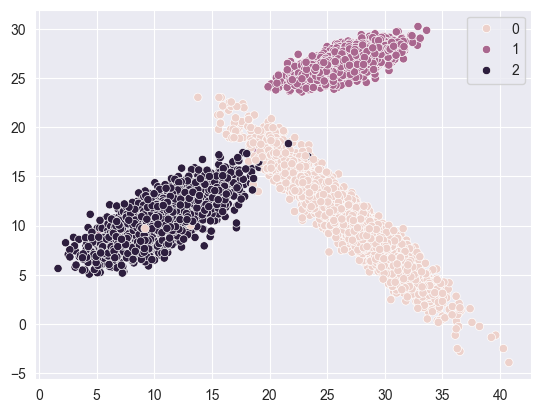

In [37]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [38]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', OneVsOneClassifier(LogisticRegression()))
])

In [39]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('clf', OneVsOneClassifier(estimator=LogisticRegression()))])

/var/folders/dv/l5yj1vt95y51qzyhmdns2cgw0000gn/T/ipykernel_61732/3750541942.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


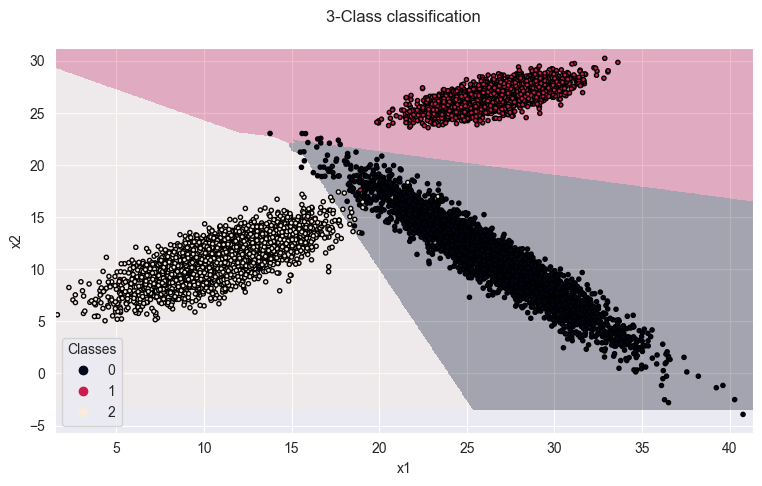

In [40]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay


fig, ax = plt.subplots(figsize=(9, 5))
disp = DecisionBoundaryDisplay.from_estimator(
    pipe,
    X_test,
    response_method="predict",
    plot_method="pcolormesh",
    grid_resolution=1000,
    xlabel='x1',
    ylabel='x2',
    shading="auto",
    alpha=0.3,
    ax=ax,
)
scatter = disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", marker='.')
disp.ax_.legend(
    scatter.legend_elements()[0],
    [0, 1, 2],
    loc="lower left",
    title="Classes",
)
disp.ax_.set_title(
    f"3-Class classification\n"
)

fig.show()

In [41]:
n_classes = 3

In [42]:
coding_matrix_ova = np.array([
    [ 1, -1, -1],
    [-1,  1, -1],
    [-1, -1,  1],
])

coding_matrix_ovo = np.array([
    [ 0,  1,  1],
    [ 1,  0, -1],
    [-1, -1,  0],
])


# L = 2^k-1 - 1
coding_matrix_full = np.array([
    [-1, -1, -1,  1,  1,  1],
    [-1,  1,  1, -1, -1,  1],
    [ 1, -1,  1, -1,  1, -1],
])

In [43]:
def prepare_dataset(X, y, coding_design):
    y_new = np.zeros_like(y)
    dropped = np.zeros_like(y)
    X_new = X.copy()
    for class_label, is_included in enumerate(coding_design):
        if is_included == 1:
            y_new += (y == class_label).astype('int64')
        elif is_included == -1:
            pass
        elif is_included == 0:
            dropped += (y == class_label).astype('int64')
    return X_new[dropped == 0], y_new[dropped == 0]
        

In [44]:
classifiers = []

In [45]:
for column in range(coding_matrix_ova.shape[1]):
    X_new_train, y_new_train = prepare_dataset(X_train, y_train, coding_matrix_ova[:, column])
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression())
    ])
    
    pipe.fit(X_new_train, y_new_train)
    classifiers.append(pipe)

In [46]:
classifiers

[Pipeline(steps=[('scale', StandardScaler()), ('clf', LogisticRegression())]),
 Pipeline(steps=[('scale', StandardScaler()), ('clf', LogisticRegression())]),
 Pipeline(steps=[('scale', StandardScaler()), ('clf', LogisticRegression())])]

### Decoding

In [54]:
scores = np.zeros(shape=(y_test.shape[0], n_classes))
scores_weighted = np.zeros(shape=(y_test.shape[0], n_classes))

for coding_number, learner in enumerate(classifiers):
    scaled_probas = (2 * learner.predict_proba(X_test)[:, 0] - 1).reshape(-1, 1)
    scores += scaled_probas * coding_matrix_ova[:, coding_number]
    scores_weighted += (scaled_probas 
                        * coding_matrix_ova[:, coding_number] 
                        / np.abs(coding_matrix_ova[:, coding_number]))  
    
scores = scores.argmax(axis=1)
scores_weighted = scores_weighted.argmax(axis=1)

#### Score-based decoding
$$ s_k=\sum^{L}_{l=1}{m_{kl}\varphi_{l}\left(x,w_l\right)} $$


#### Score-weighted decoding
$$ s_k=\frac{\sum^{L}_{l=1}{m_{kl}\varphi_{l}\left(x,w_l\right)}}{\sum^{L}_{l=1}{\left|m_{kl}\right|}} $$


$$ k^{*}= \arg \underset{k=\overline{1,K}}\max s_k $$


In [55]:
scores

array([1, 0, 2, ..., 1, 2, 2])